# IRC


In [1]:
%reload_ext autoreload
%autoreload 2


In [2]:
import sys
import os
from pathlib import Path
import configparser
config = configparser.ConfigParser()
config.read_file(open('../../privateconfig'))
resdir = Path(config['Datafolder']['data'])
workdir = Path(config['Codefolder']['workspace'])
os.chdir(workdir)

In [3]:
from scipy.io import loadmat
import numpy as np
from datetime import date
from notification import notify
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.ndimage import gaussian_filter1d
import pickle
import pandas as pd
from plot_ult import *
import warnings
from scipy.stats import pearsonr
from env_config import Config
from firefly_task import ffacc_real
from monkey_functions import *
from InverseFuncs import *
from numpy import pi
from stable_baselines3 import TD3
import torch
import time
tic=time.time()
warnings.filterwarnings('ignore')

C:\Users\24455\miniconda3\envs\lab\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\24455\miniconda3\envs\lab\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\24455\miniconda3\envs\lab\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


# Pre IRC

convert the mat data file (with neural data) into (states, actions, tasks) for IRC.


## prepare

In [4]:
# const
bin_size = 17 # how many bin of DT. about 0.1 s
num_bins = 24 # how many bins to use. use 2.4 s and discard the long trials.
monkey_height = 10
DT = 0.006 # DT for raw data
reward_boundary = 65
areas = ['PPC', 'PFC', 'MST']
t_total = 24
fontsize = 7; lw = 1
worldscale =200

m = 'm51'

folder='m51_mat_ruiyi'
dens=[0.0001, 0.0005, 0.001,  0.005]

locals().update({m: {}})
figure_path = resdir/'figures'
# datapaths = [i for i in Path(resdir/'mat_ruiyi').glob(f'{m}*.mat')]
datapaths=[i for i in Path(resdir/folder).glob(f'{m}*.mat')]

datapaths,m

([WindowsPath('C:/Users/24455/Desktop/repo/mkdata/m51_mat_ruiyi/m51s38.mat'),
  WindowsPath('C:/Users/24455/Desktop/repo/mkdata/m51_mat_ruiyi/m51s40.mat'),
  WindowsPath('C:/Users/24455/Desktop/repo/mkdata/m51_mat_ruiyi/m51s41.mat'),
  WindowsPath('C:/Users/24455/Desktop/repo/mkdata/m51_mat_ruiyi/m51s42.mat'),
  WindowsPath('C:/Users/24455/Desktop/repo/mkdata/m51_mat_ruiyi/m51s43.mat')],
 'm51')

## helper functions

In [5]:
# helper functions
def distance(x,y):
    return (x**2+y**2)**0.5
    
def set_violin_plot(vp, facecolor, edgecolor, linewidth=1, alpha=1, ls='-', hatch=r''):
    plt.setp(vp['bodies'], facecolor=facecolor, edgecolor=edgecolor, 
             linewidth=linewidth, alpha=alpha ,ls=ls, hatch=hatch)
    plt.setp(vp['cmins'], facecolor=facecolor, edgecolor=edgecolor, 
             linewidth=linewidth, alpha=alpha)
    plt.setp(vp['cmaxes'], facecolor=facecolor, edgecolor=edgecolor, 
             linewidth=linewidth, alpha=alpha)
    plt.setp(vp['cbars'], facecolor=facecolor, edgecolor=edgecolor, 
             linewidth=linewidth, alpha=alpha)
    
    linecolor = 'k' if facecolor == 'None' else 'snow'
    if 'cmedians' in vp:
        plt.setp(vp['cmedians'], facecolor=linecolor, edgecolor=linecolor, 
                 linewidth=linewidth, alpha=alpha)
    if 'cmeans' in vp:
        plt.setp(vp['cmeans'], facecolor=linecolor, edgecolor=linecolor, 
                 linewidth=linewidth, alpha=alpha)
       
        
def downsample(data, bin_size=20):
    num_bin = data.shape[0] // bin_size
    data_ = data[:bin_size * num_bin]
    data_ = data_.reshape(num_bin, bin_size, data.shape[-1])
    data_ = np.nanmean(data_, axis=1)
    return data_



def convert_location_to_angle(gaze_r, gaze_x, gaze_y, body_theta, body_x, body_y, hor_theta_eye, ver_theta_eye,monkey_height=monkey_height, DT=DT, remove_pre=True, remove_post=True):
    '''
        convert the world overhead view location of the 'gaze' location to eye coord. 

        gaze location, the target
        gaze_r, relative distance
        gaze_x, gaze location x
        gaze_y,

        body_theta, heading direction
        body_x, monkey location x
        body_y, 

        hor_theta_eye, actual eye location in eye coord. used here to remove pre saccade (when monkey hasnt seen the target yet)
        ver_theta_eye
    '''

    #hor_theta = -np.rad2deg(np.arctan2(-(gaze_x - body_x), gaze_y - body_y) - (body_theta-np.deg2rad(90))).reshape(-1, 1) 
    hor_theta = -np.rad2deg(np.arctan2(-(gaze_x - body_x), np.sqrt((gaze_y - body_y)**2 + monkey_height**2))
                            - (body_theta-np.deg2rad(90))).reshape(-1, 1) 

    k = -1 / np.tan(body_theta); b = body_y - k * body_x
    gaze_r_sign = (k * gaze_x + b < gaze_y).astype(int)
    gaze_r_sign[gaze_r_sign == 0] = -1
    ver_theta = -np.rad2deg(np.arctan2(monkey_height, gaze_r_sign * gaze_r)).reshape(-1, 1)

    # remove overshooting
    if remove_post:
        overshoot_idx = np.where(((gaze_x - body_x) * gaze_x < 0) | (gaze_y < body_y)
                                #| (abs(hor_theta.flatten()) > 60)
                                )[0]
        if overshoot_idx.size > 0:
            hor_theta[overshoot_idx[0]:] = np.nan

        overshoot_idx = np.where((gaze_r_sign < 0)
                                #| (abs(ver_theta.flatten()) > 60)
                                )[0]
        if overshoot_idx.size > 0:
            ver_theta[overshoot_idx[0]:] = np.nan
        
    # detect saccade
    if remove_pre:
        if hor_theta_eye.size > 2:
            saccade = np.sqrt((np.gradient(hor_theta_eye) / DT)**2 + 
                            (np.gradient(ver_theta_eye) / DT)**2)
            saccade_start_idx = np.where(saccade > 100)[0]
            saccade_start_idx = saccade_start_idx[0] + 16 if saccade_start_idx.size > 0 else None

            hor_theta[:saccade_start_idx] = np.nan
            ver_theta[:saccade_start_idx] = np.nan
        
    return hor_theta, ver_theta


def compute_error(data1, data2, mask):
    #data1 = data1[~mask]; data2 = data2[~mask]
    #corr = np.corrcoef(data1, data2)
    error = abs(data1 - data2)
    
    rng = np.random.default_rng(seed=0)
    data1_ = data1.copy(); data2_ = data2.copy()
    rng.shuffle(data1_); rng.shuffle(data2_)
    error_shuffle = abs(data1_ - data2_)
    return error



## load raw data (same as ruiyi script)

In [6]:
# load raw data
for idx, datapath in enumerate(datapaths):
    if datapath.stem[-1].isalpha():
        continue
    data = loadmat(datapath)
    eval(m)[datapath.stem] = data
    notify(datapath)
    
notify('all done! loaded')

## Neural

In [7]:
m_neural = {}
for key, data in eval(m).items():
    if key[-1].isalpha():
        continue
    trials_behv = data['trials_behv'][0]
    trials_units = data['units'][0]
    
    trials_neural = []
    for trial_idx, trial_behv in enumerate(trials_behv):
        trial_ts = trial_behv['continuous']['ts'][0][0].reshape(-1)

        activities = []
        for trials_unit in trials_units:
            fire_ts = trials_unit['trials'][0][trial_idx][0].reshape(-1)
            if fire_ts.size > 0 and fire_ts[-1] >= trial_ts[-1]:
                fire_ts = fire_ts[:-1]
            activity = np.zeros_like(trial_ts)
            bin_indices = np.digitize(fire_ts, trial_ts)
            unique_bins, bin_counts = np.unique(bin_indices, return_counts=True)
            activity[unique_bins] = bin_counts
            activities.append(activity)

        activities = np.vstack(activities).T   # time * unit
        activities = gaussian_filter1d(activities, sigma=4, axis=0)
        trials_neural.append(activities)    
    m_neural[key + 'neural'] = trials_neural
    
eval(m).update(m_neural)
del m_neural
    
num_bins = 24; bin_size = 17; monkey_height = 10
areas = ['PPC', 'PFC', 'MST']
m_extracted_continuous = {}; m_downsampled = {}; m_errors = {}
for key, data in eval(m).items():
    if key[-1].isalpha():
        continue
        
    trials_behv = data['trials_behv'][0]
    trials_units = data['units'][0]
    units_area = np.array([v[0] for v in trials_units['brain_area']])
    
    Xt = dict(zip(areas, [[[] for _ in range(num_bins)] for area in areas])) 
    Xdownsampled = dict(zip(areas, [[] for area in areas])) 
    
    for trial_idx, trial_behv in enumerate(trials_behv):
        trial_ts = trial_behv['continuous']['ts'][0][0].reshape(-1)
        t_mask = (trial_ts > 0) & (~np.isnan(trial_behv['continuous']['ymp'][0][0].reshape(-1)))
        t_mask &= trial_ts < trial_behv['events']['t_stop'][0][0].reshape(-1)
        if t_mask.sum() > 0:
            t_mask[np.where(t_mask == True)[0][0]] = False # remove the first data point to avoid downsample error

        # for Xt
        activity = eval(m)[key + 'neural'][trial_idx][t_mask]
        activity = downsample(activity, bin_size=bin_size)
        for area in areas:
            area_mask = [v in area for v in units_area]
            if sum(area_mask) == 0:
                continue
            activity_ = activity[:, area_mask]
            Xdownsampled[area].append([trial_idx, activity_])
            for bin_idx in range(num_bins):
                if activity_.shape[0] > bin_idx:
                    Xt[area][bin_idx].append([trial_idx, activity_[bin_idx]])
                    #Xt[area][bin_idx].append([trial_idx, activity_[-(bin_idx+1)]])

    m_downsampled[key + 'Xdownsampled'] = Xdownsampled
    
eval(m).update(m_downsampled)
del m_downsampled


## y downsample

In [8]:
m_extracted_continuous = {}; m_downsampled = {}; m_errors = {}
m_dens={}

for key, data in eval(m).items():
    
    if key[-1].isalpha():
        continue
        
    trials_behv = data['trials_behv'][0]
    trials_units = data['units'][0]
    units_area = np.array([v[0] for v in trials_units['brain_area']])
    Xt = dict(zip(areas, [[[] for _ in range(num_bins)] for area in areas])) 
    Xdownsampled = dict(zip(areas, [[] for area in areas])) 

    Ydownsampled = []
    Y = []
    trials_error = []; trials_error_sign = []; trials_target_angle = []; trials_target_distance = []
    trial_dens=[]
    for trial_idx, trial_behv in enumerate(trials_behv):
        
        # [0.0001 0.0005 0.001  0.005 ]
        # if trial_behv['prs'][0][0]['floordensity'] != density:
        #     continue
        

        trial_ts = trial_behv['continuous']['ts'][0][0].reshape(-1)
        t_mask = (trial_ts > 0) & (~np.isnan(trial_behv['continuous']['ymp'][0][0].reshape(-1)))
        t_mask &= trial_ts < trial_behv['events']['t_stop'][0][0].reshape(-1)
        if t_mask.sum() > 0:
            t_mask[np.where(t_mask == True)[0][0]] = False # remove the first data point to avoid downsample error
        
        # get Y
        mx = trial_behv['continuous']['xmp'][0][0][t_mask]
        my = trial_behv['continuous']['ymp'][0][0][t_mask]
        fx = trial_behv['continuous']['xfp'][0][0][t_mask]
        fy = trial_behv['continuous']['yfp'][0][0][t_mask]
        sx = np.ones_like(fx); sy = np.ones_like(fy)
        if my.size > 0:
            fx = np.ones_like(fx) * fx[0]
            fy = np.ones_like(fy) * fy[0]
            sx *= mx[-1]; sy *= my[-1]
            my = my + 30; fy = fy + 30; sy = sy + 30
        
        dx = fx - mx; dy = fy - my
        rel_dist = np.sqrt(dx**2 + dy**2); rel_ang = np.rad2deg(np.arctan2(dy, dx))
        rel_dist_stop = np.sqrt((sx - mx)**2 + (sy - my)**2)
        
        if my.size > 0:
            trials_error.append(rel_dist[-1][0])
            trials_error_sign.append(rel_dist[-1][0])
            trials_target_angle.append(np.rad2deg(np.arctan2(fy, fx))[-1][0] - 90)
            trials_target_distance.append(np.sqrt(fx**2 + fy**2)[-1][0])
            
        else:
            trials_error.append(np.nan)
            trials_error_sign.append(np.nan)
            trials_target_angle.append(np.nan)
            trials_target_distance.append(np.nan)
        
        if my.size > 0:
            d1 = np.sqrt(fx**2 + fy**2)
            r1 = (fx**2 + fy**2) / (2*fx)
            radian1 = 2 * r1 * np.arcsin(d1 / (2 * r1))

            d2 = np.sqrt(mx**2 + my**2)
            r2 = (mx**2 + my**2) / (2*mx + 1e-8)
            radian2 = 2 * r2 * np.arcsin(d2 / (2 * r2 + 1e-8))

            sign = np.ones_like(rel_dist)
            sign[radian2 < radian1] = -1
            rel_dist = sign * rel_dist
            trials_error_sign[-1] = rel_dist[-1][0]
        
        abs_dist = np.sqrt(mx**2 + my**2); abs_ang = np.rad2deg(np.arctan2(my, mx))

        eye_hor_theta = trial_behv['continuous']['yre'][0][0][t_mask]
        eye_ver_theta = trial_behv['continuous']['zre'][0][0][t_mask]
        # eye_hor_theta = trial_behv['continuous']['yle'][0][0][t_mask] # m51 has no left eye
        # eye_ver_theta = trial_behv['continuous']['zle'][0][0][t_mask]
        mw = -trial_behv['continuous']['w'][0][0][t_mask].reshape(-1)
        body_theta = np.deg2rad(np.cumsum(mw) * DT + 90)
        body_x, body_y = mx.reshape(-1), my.reshape(-1)
        
        latent_ff_hori, latent_ff_vert = convert_location_to_angle(abs(rel_dist).reshape(-1), fx.reshape(-1), fy.reshape(-1),
            body_theta, body_x, body_y, 
            eye_hor_theta.reshape(-1), eye_ver_theta.reshape(-1), remove_pre=False, remove_post=False)

        mv = trial_behv['continuous']['v'][0][0][t_mask].reshape(-1,1)
        mw = trial_behv['continuous']['w'][0][0][t_mask].reshape(-1,1)
        if t_mask.sum() * DT > 3.5 or t_mask.sum() * DT < 0.6 or mv.max() < 50 or \
            abs_dist[-1] < np.sqrt(fx**2 + fy**2)[-1] * 0.3:
            continue
        
        trial_dens.append(trial_behv['prs'][0][0]['floordensity'])
        
        target_variable = np.hstack([rel_dist, rel_ang, abs_dist, abs_ang,
                                     eye_hor_theta, eye_ver_theta, latent_ff_hori, latent_ff_vert,
                                     fx, fy, mx, my, mv, mw])
        Y.append(target_variable)
        target_variable = downsample(target_variable, bin_size=bin_size)
        
        # compute the latent ff in eye cord after downsample, to compare wt belief
        (rel_dist, rel_ang, abs_dist, abs_ang,
                                            eye_hor_theta, eye_ver_theta, latent_ff_hori, latent_ff_vert,
                                            fx, fy, mx, my, mv, mw)=zip(*target_variable)
        body_theta = -np.deg2rad(np.cumsum(mw) * 0.1 -90)
        body_x, body_y = np.array(mx).reshape(-1), np.array(my).reshape(-1)

        latent_ff_hori, latent_ff_vert = convert_location_to_angle(abs(np.array(rel_dist)).reshape(-1), np.array(fx).reshape(-1), np.array(fy).reshape(-1),
            np.array(body_theta), np.array(body_x), np.array(body_y), 
            np.array(eye_hor_theta).reshape(-1), np.array(eye_ver_theta).reshape(-1), remove_pre=False)

        target_variable = np.vstack([rel_dist, rel_ang, abs_dist, abs_ang,
                                     eye_hor_theta, eye_ver_theta, latent_ff_hori.reshape(-1), latent_ff_vert.reshape(-1),
                                     fx, fy, mx, my, mv, mw]).T
        
        # end compute the latent ff with downsampled y
        Ydownsampled.append([trial_idx, target_variable])

        # for Xt
        activity = eval(m)[key + 'neural'][trial_idx][t_mask]
        activity = downsample(activity, bin_size=bin_size)
        for area in areas:
            area_mask = [v in area for v in units_area]
            if sum(area_mask) == 0:
                continue
            activity_ = activity[:, area_mask]
            Xdownsampled[area].append([trial_idx, activity_])
            for bin_idx in range(num_bins):
                if activity_.shape[0] > bin_idx:
                    Xt[area][bin_idx].append([trial_idx, activity_[bin_idx]])
                    #Xt[area][bin_idx].append([trial_idx, activity_[-(bin_idx+1)]])

    m_downsampled[key + 'Xdownsampled'] = Xdownsampled
    m_extracted_continuous[key + 'Y'] = Y
    m_downsampled[key + 'Ydownsampled'] = Ydownsampled
    m_dens[key+'_dens']=trial_dens
    m_errors[key + 'error'] = trials_error; m_errors[key + 'error_sign'] = trials_error_sign
    m_errors[key + 'target_angle'] = trials_target_angle; m_errors[key + 'target_distance'] = trials_target_distance
    
eval(m).update(m_downsampled); eval(m).update(m_extracted_continuous); eval(m).update(m_errors);eval(m).update(m_dens)
# del m_downsampled, m_extracted_continuous, m_errors

In [9]:
# m_downsampled.keys()
Xdownsampled.keys()
np.array(Xdownsampled['PPC']).shape, np.array(Xdownsampled['PFC']).shape,np.array(Xdownsampled['MST']).shape


trial_idces, yy = zip(*Xdownsampled['PPC'])
# len(trial_idces)
print(np.vstack(yy).shape, len(yy))
trial_idces, yy = zip(*Ydownsampled)
print(np.vstack(yy).shape, len(yy))



(18985, 94) 1252
(18985, 14) 1252


In [10]:
len(m51['m51s42_dens']),len(m51['m51s42Ydownsampled'])


(1196, 1196)

## IRC input data (state, action, task)

In [11]:
irc_input_data={}

for key, data in eval(m).items():
    if not key.endswith('Ydownsampled'):
        continue
    states, actions, tasks=[],[],[]
    
    print(key)
    y=eval(m)[key]
    trial_idces, yy = zip(*y)

    for itrial in range(len(trial_idces)):
        (rel_dist, rel_ang, abs_dist, abs_ang,
                                     eye_hor_theta, eye_ver_theta, latent_ff_hori, latent_ff_vert,
                                     fx, fy, mx, my, mv, mw)=zip(*yy[itrial])
        # task
        taskx = (fx[0] - mx[0]).astype('float32'); tasky = (fy[0] - my[0]).astype('float32')
        tasks.append([tasky/worldscale,taskx/worldscale])
        # actions
        trialaction=np.stack([mv,mw]).T
        trialaction[:,0]=trialaction[:,0]/worldscale # v need reduce scale
        trialaction[:,1]=trialaction[:,1]/180*pi
        actions.append(trialaction.astype('float32'))

        # states from run the actions
        px, py, heading, v, w = 0,0,0,0,0
        log=[]
        for a in trialaction:
            px, py, heading, v, w=state_step2(px, py, heading, v, w, a, dt=0.1,userad=True)
            log.append([px, py, heading, v, w])
        px, py, heading, v, w=state_step2(px, py, heading, v, w, a, dt=0.1,userad=True)
        log.append([px, py, heading, v, w])
        trialstates=np.array(log)[1:]
        
        states.append(trialstates.astype('float32'))

    irc_input_data[key + '_irc']=(states, actions, tasks)

eval(m).update(irc_input_data)
del irc_input_data


m51s38Ydownsampled
m51s40Ydownsampled
m51s41Ydownsampled
m51s42Ydownsampled
m51s43Ydownsampled


## compute belief 

In [12]:
# model estimated likelihood (negative)
torch.manual_seed(42)
arg = Config()

env = ffacc_real.FireFlyPaper(arg)
env.debug=True
phi = torch.tensor([[0.5],
                    [pi/2],
                    [0.001],
                    [0.001],
                    [0.001],
                    [0.001],
                    [0.13],
                    [0.001],
                    [0.001],
                    [0.001],
                    [0.001],
                    ])

agent_ = TD3.load('trained_agent/paper.zip')
agent = agent_.actor.mu.cpu()

def lltrial(state, action, task,samples=5):
    with torch.no_grad():
        return monkeyloss_(agent, action, task, phi, finaltheta, env, action_var=0.01, num_iteration=1, states=state, samples=samples, gpu=False).item()
    

# irc_ll={}
# for key, data in eval(m).items():
#     if not key.endswith('irc'):
#         continue
#     states, actions, tasks=eval(m)[key]

#     sessionll=[]
#     for i in range(len(states)):
#         state, action, task=[states[i]], [actions[i]], [tasks[i]]
#         ll=lltrial(state, action, task)
#         sessionll.append(ll)
#         if i%100==0: print(i)
#     irc_ll[key+'_ll']=sessionll

# notify('all done')

In [13]:
thetas={}
for idensity in range(4):
    datapath = Path(resdir/f'{m}_mat_ruiyi/preirc_den_{idensity}')
    savename = datapath.parent/(f'{m}_{idensity}'+datapath.name)
    invfile=savename
    print(datapath.name)
    finaltheta, finalcov, err = process_inv(
        invfile, removegr=False, usingbest=False)
    print(finaltheta[:4])
    # finaltheta[0]=1
    # finaltheta[1]=1.3
    # finaltheta[1]=0.5
    # finaltheta[1]=0.2
    thetas[idensity]=finaltheta


preirc_den_0
C:\Users\24455\Desktop\repo\mkdata\m51_mat_ruiyi\m51_0preirc_den_0
using ind:  -1 final logll :  16.993248803274973
tensor([[0.9924],
        [0.7905],
        [0.7104],
        [0.1499]])
preirc_den_1
C:\Users\24455\Desktop\repo\mkdata\m51_mat_ruiyi\m51_1preirc_den_1
using ind:  -1 final logll :  15.665690626416888
tensor([[1.1921],
        [0.8381],
        [0.6041],
        [0.1469]])
preirc_den_2
C:\Users\24455\Desktop\repo\mkdata\m51_mat_ruiyi\m51_2preirc_den_2
using ind:  -1 final logll :  16.006959642682755
tensor([[1.1985],
        [0.9138],
        [0.5796],
        [0.1894]])
preirc_den_3
C:\Users\24455\Desktop\repo\mkdata\m51_mat_ruiyi\m51_3preirc_den_3
using ind:  -1 final logll :  15.557111876351494
tensor([[1.1422],
        [0.8885],
        [0.5519],
        [0.1930]])


In [25]:
# compute belief
today='0110'
skipblief=not(date.today().strftime("%m%d") == today)

if not skipblief: # compute new belief and save with today date
    all_beliefs, all_covs={},{}
    denslookup={0.0001:0, 0.0005:1, 0.001:2,  0.005:3}
    for key, data in eval(m).items():
        if not key.endswith('irc'):
            continue
        datakey=key[:-16] # something like m51s11
        dens=np.concatenate(eval(m)[datakey+'_dens']).reshape(-1)
        states, actions, tasks=eval(m)[key]
        beliefs, covs = [], []
        ntrial = 1
        # theta = finaltheta

        for ind in range(len(tasks)):
            if ind%100==0:
                print(ind)
            if len(actions[ind]) < 5:
                beliefs.append(np.nan)
                covs.append(np.nan)
            else:
                den=dens[ind]
                theta=thetas[denslookup[den]]
                _, _, ep_beliefs, ep_covs = run_trials(agent=agent, env=env, phi=phi, theta=theta, task=tasks[ind], ntrials=ntrial,
                                                    pert=None, given_obs=None, return_belief=True, given_action=actions[ind], given_state=states[ind])
                # beliefs.append(ep_beliefs[0]-ep_beliefs[0][0])
                init=torch.tensor(states[ind][0]).reshape(-1,1)
                beliefs.append(ep_beliefs[0]-ep_beliefs[0][0]+init) # make belief and state start at the same place
                covs.append(ep_covs[0])
                assert len(ep_beliefs[0]) == len(actions[ind])
        all_beliefs[f'{key[:-4]}_irc_belief']=beliefs
        all_covs[f'{key[:-4]}_irc_cov']=covs
    notify('done computing belief')
    today = date.today().strftime("%m%d") # mm/dd
    with open(resdir/f'{folder}/irc_belief_{today}','wb+') as f:
        pickle.dump((all_beliefs, all_covs),f)

else: # use the given day
    print(f'use computed belief from day {today}')
    with open(resdir/f'{folder}/irc_belief_{today}','rb') as f:
        all_beliefs, all_covs=pickle.load(f)




0
100
200
300
400
500
600
0
100
200
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
0
100
200
300
400
500
600
700
800
900
1000
1100
0
100
200
300
400
500
600
700
800
900
1000
1100
1200


## compute likelihood
todo, need to do this trial by trial to take account of density.

In [15]:
today=1117
skipll=not(date.today().strftime("%m%d") == today)

def lltrial(state, action, task, finaltheta, samples=5):
    with torch.no_grad():
        return monkeyloss_(agent, action, task, phi, finaltheta, env, action_var=0.01, num_iteration=1, states=state, samples=samples, gpu=False).item()
    
if not skipll: # compute new ll and save with today date
    irc_ll={}
    for key, data in eval(m).items():
        if not key.endswith('irc'):
            continue
        states, actions, tasks=eval(m)[key]
        datakey=key[:-16] # something like m51s11
        dens=np.concatenate(eval(m)[datakey+'_dens']).reshape(-1)

        sessionll=[]
        for i in range(len(states)):
            state, action, task=[states[i]], [actions[i]], [tasks[i]]
            den=dens[i]
            ll=lltrial(state, action, task, thetas[denslookup[den]])
            sessionll.append(ll)
            if i%100==0: print(i)
        irc_ll[key+'_ll']=sessionll
    notify('all done')
    today = date.today().strftime("%m%d") # mm/dd
    with open(resdir/f'{folder}/irc_ll_{today}','wb+') as f:
        pickle.dump(irc_ll,f)

else: # use the given day
    print(f'use computed likelihood from day {today}')
    with open(resdir/f'{folder}/irc_ll_{today}','rb') as f:
        irc_ll=pickle.load(f)

  

use computed likelihood from day 1117


In [31]:
eval(m).update(all_beliefs)
eval(m).update(all_covs)
eval(m).update(irc_ll)

## convert to eye coord

In [32]:
# currently do not remove pre saccade and after overshoot
all_latent_ff_belief = {}

for key, data in eval(m).items():
    if not key.endswith('irc'):
        continue
    print(key)
    sess_latentff_hori, sess_latentff_vert = [], []
    beliefs, covs = eval(m)[f'{key}_belief'],  eval(m)[f'{key}_cov']
    states, actions, tasks = eval(m)[f'{key}']
    for ep_beliefs, ep_covs, task in zip(beliefs, covs, tasks):
        mx, my, body_theta,  mv, mw = zip(*ep_beliefs)
        body_theta = -(np.cumsum(mw) * 0.1-pi/2)
        body_x, body_y = np.asarray(my).reshape(-1).astype('float') * \
            worldscale, np.asarray(mx).reshape(-1).astype('float')*worldscale

        fx, fy = task[1]*worldscale, task[0]*worldscale
        rel_dist = ((fx-body_x)**2+(fy-body_y)**2)**0.5
        hor_theta_, ver_theta_ = convert_location_to_angle(abs(np.array(rel_dist)).reshape(-1).astype('float'), np.array(fx).reshape(-1).astype('float'), np.array(fy).reshape(-1).astype('float'),
                                                           body_theta.astype('float'), body_x.astype(
                                                               'float'), body_y.astype('float'),
                                                           np.array(rel_dist).reshape(-1).astype('float'), # use the true eye positions to remove pre saccade movement and after overshooting eye movement
                                                           np.array(rel_dist).reshape(-1).astype('float'), DT=0.1, remove_pre=False, remove_post=False)
        # plt.plot(hor_theta_, ver_theta_, 'g')
        sess_latentff_hori.append(hor_theta_)
        sess_latentff_vert.append(ver_theta_)

    all_latent_ff_belief[f'{key[:-3]}belief_eye'] = sess_latentff_hori, sess_latentff_vert



m51s38Ydownsampled_irc
m51s40Ydownsampled_irc
m51s41Ydownsampled_irc
m51s42Ydownsampled_irc
m51s43Ydownsampled_irc


# analysis

In [33]:
all_eye_coord={} # contain all eye coord trajectories, and related vars

for key in ['m51s42','m51s38', 'm51s40', 'm51s41', 'm51s43']:
 
    beliefs, covs = eval(m)[f'{key}Ydownsampled_irc_belief'],  eval(m)[f'{key}Ydownsampled_irc_cov']
    states, actions, tasks=eval(m)[f'{key}Ydownsampled_irc']
    sess_ll=eval(m)[f'{key}Ydownsampled_irc_ll']
    sess_ll=np.array(sess_ll)
    sess_latentb_hori, sess_latentb_vert=all_latent_ff_belief[f'{key}Ydownsampled_belief_eye']
    y = eval(m)[f'{key}Ydownsampled']
    trial_idces, yy=zip(*y)

    sess_latentff_hori, sess_latentff_vert=[],[]
    sess_eye_hori, sess_eye_vert=[],[]
    sess_err=[];sess_err_belief=[]
    sess_angle_from_start=[]
    for itrial in range(len(trial_idces)):
        (rel_dist, rel_ang, abs_dist, abs_ang,
                                        eye_hor_theta, eye_ver_theta, latent_ff_hori, latent_ff_vert,
                                        fx, fy, mx, my, mv, mw)=zip(*yy[itrial])

        sess_latentff_hori.append(latent_ff_hori)
        sess_latentff_vert.append(latent_ff_vert)
        sess_eye_hori.append(eye_hor_theta)
        sess_eye_vert.append(eye_ver_theta)
        ep_err=distance((fx[-1]-mx[-1]),(fy[-1]-my[-1]))
        sess_err+=[ep_err]*len(rel_dist)
        sess_angle_from_start+=np.arctan2((np.array(my)),(np.array(mx))).tolist()

    sess_latentff_hori=np.concatenate(sess_latentff_hori)
    sess_latentff_vert=np.concatenate(sess_latentff_vert)
    sess_eye_hori=np.concatenate(sess_eye_hori)
    sess_eye_vert=np.concatenate(sess_eye_vert)
    sess_latentb_hori=np.concatenate(sess_latentb_hori).reshape(-1)
    sess_latentb_vert=np.concatenate(sess_latentb_vert).reshape(-1)
    sess_angle_from_start=np.array(sess_angle_from_start)

    sess_ll_t=[]
    for ll, data in zip(sess_ll, states):
        sess_ll_t+=[ll]*len(data)
    sess_ll_t=np.array(sess_ll_t)

    sess_t=[] # session trial timer
    for ll, data in zip(sess_ll, states):
        sess_t+=list(range(len(data)))
    sess_t=np.array(sess_t)
    sess_err=np.array(sess_err)

    dens=eval(m)[key+'_dens']
    dens_t=[]
    for den, data in zip(dens, states):
        dens_t+=[den]*len(data)
    dens_t=np.array(dens_t).reshape(-1)
   
    sess_err_belief=[]
    sess_angle_from_start_belief=[]
    for ep_beliefs, ep_covs, task in zip(beliefs, covs, tasks):
        mx, my, body_theta,  mv,mw= zip(*ep_beliefs)
        fx,fy=task[0]*worldscale, task[1]*worldscale
        mx, my = np.asarray(my).reshape(-1).astype('float')*worldscale, np.asarray(mx).reshape(-1).astype('float')*worldscale
        ep_err=distance((fy-mx[-1]),(fx-my[-1]))
        sess_err_belief+=[ep_err]*len(mx)
        sess_angle_from_start_belief+=np.arctan2((np.array(my)),(np.array(mx))).tolist()
    sess_err_belief=np.array(sess_err_belief)
    sess_angle_from_start_belief=np.array(sess_angle_from_start_belief)

    
    all_eye_coord[f'{key}_eye_coord']=np.stack([
        sess_eye_hori, sess_eye_vert,
        sess_latentb_hori, sess_latentb_vert,
        sess_latentff_hori, sess_latentff_vert,
        sess_ll_t, sess_t,
        sess_err,sess_err_belief,
        dens_t
    ]) # a feat by ts array.


sess_t_end=[] # get the index of trial end. use as a mask
prev=0
for i,t in enumerate(sess_t): # t is t in trial
    if t>prev:
        prev=t
    else: # add the index of the end of the trial
        sess_t_end


# all_eye_coord[list(all_eye_coord.keys())[0]].shape

state_stop_angle=[]; belief_stop_angle=[]; eye_stop_hori=[]
state_angle=[]; belief_angle=[] # with respect to the origin
state_angle_f=[]; belief_angle_f=[] # wrt firefly
state_heading, belief_heading=[],[]
# state
for itrial in range(len(trial_idces)):
    (rel_dist, rel_ang, abs_dist, abs_ang,
                                    eye_hor_theta, eye_ver_theta, latent_ff_hori, latent_ff_vert,
                                    fx, fy, mx, my, mv, mw)=zip(*yy[itrial])
    state_stop_angle.append(np.arctan2(my[-1]-my[0], mx[-1]-mx[0]))
    state_angle.append(np.arctan2( mx-mx[0],my-my[0]))
    state_angle_f.append(np.arctan2(fy-(my-my[0]), fx-(mx-mx[0])))
    eye_stop_hori.append(np.mean(eye_hor_theta))
    state_heading.append(np.cumsum(mw)*0.1)

# belief
for ep_beliefs, ep_covs, task in zip(beliefs, covs, tasks):
    mx, my, body_theta,  mv,mw= zip(*ep_beliefs)
    fx,fy=task[0]*worldscale, task[1]*worldscale
    mx, my = np.asarray(my).reshape(-1).astype('float')*worldscale, np.asarray(mx).reshape(-1).astype('float')*worldscale
    belief_angle.append(np.arctan2( mx-mx[0],my-my[0]))
    belief_angle_f.append(np.arctan2(fy-(my-my[0]), fx-(mx-mx[0])))
    belief_stop_angle.append(np.arctan2(my[-1]-my[0], mx[-1]-mx[0]))
    belief_heading.append(body_theta)


eye_stop_hori=np.array(eye_stop_hori)
state_stop_angle=np.hstack(state_stop_angle)
belief_stop_angle=np.hstack(belief_stop_angle)
state_angle=np.hstack(state_angle)
belief_angle=np.hstack(belief_angle)
state_angle_f=np.hstack(state_angle_f)
belief_angle_f=np.hstack(belief_angle_f)
state_belief_diff_stop_angle=np.abs(state_stop_angle-belief_stop_angle) # use to mask when plot
state_heading=np.hstack(state_heading);belief_heading=np.hstack(belief_heading).astype('float')
belief_heading.shape, sess_eye_hori.shape

((18985,), (18985,))

In [34]:

for key in ['m51s42','m51s38', 'm51s40', 'm51s41', 'm51s43']:
    neural = eval(m)[f'{key}Xdownsampled']
    _,r_ppc = zip(*neural['PPC'])
    # _,r_pfc = zip(*neural['PFC'])
    # _,r_mst = zip(*neural['MST'])

r_ppc_t=np.vstack(r_ppc)
# r_pfc_t=np.vstack(r_pfc)
# r_mst_t=np.vstack(r_mst)
r_ppc_t.shape

(18985, 94)

In [35]:
toc=time.time()
time_elapse=toc-tic
notify(f'all finish {time_elapse:.0f} sec')

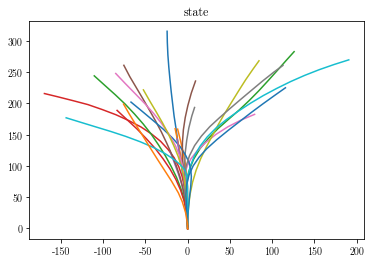

Text(0.5, 1.0, 'belief')

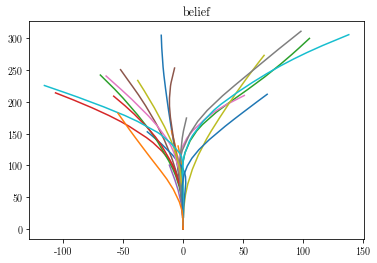

In [38]:
for itrial in range(22):
    (rel_dist, rel_ang, abs_dist, abs_ang,
                                    eye_hor_theta, eye_ver_theta, latent_ff_hori, latent_ff_vert,
                                    fx, fy, mx, my, mv, mw)=zip(*yy[itrial])
    plt.plot(mx, my)

    # plt.plot(np.arctan2(my,mx))
plt.title('state')
plt.show()
for ep_beliefs, ep_covs, task in zip(beliefs[:22], covs[:22], tasks[:22]):
    mx, my, body_theta,  mv,mw= zip(*ep_beliefs)
    fx,fy=task[0]*worldscale, task[1]*worldscale
    mx, my = np.asarray(my).reshape(-1).astype('float')*worldscale, np.asarray(mx).reshape(-1).astype('float')*worldscale
    plt.plot(mx, my)
    # plt.plot(np.arctan2(my,mx))
plt.title('belief')

### visualize the belief cov and state stop

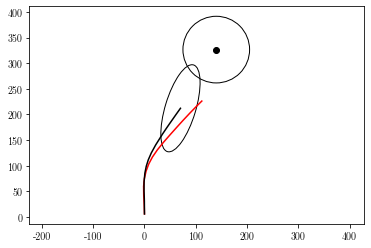

In [39]:
# plot state and belief together

fig, ax=plt.subplots(1,1)
# for itrial in range(len(trial_idces)):
itrial-=1

# # y downsample states
# (rel_dist, rel_ang, abs_dist, abs_ang,
#                                 eye_hor_theta, eye_ver_theta, latent_ff_hori, latent_ff_vert,
#                                 fx, fy, mx, my, mv, mw)=zip(*yy[itrial])
# ep_err=distance((fx[-1]-mx[-1]),(fy[-1]-my[-1]))
# plt.plot( np.array(mx), my ,'g')

# pre irc states
ep_states=states[itrial]
mx, my, body_theta,  mv,mw= zip(*ep_states)
fx,fy=task[0]*worldscale, task[1]*worldscale
mx, my = np.asarray(my).reshape(-1).astype('float')*worldscale, np.asarray(mx).reshape(-1).astype('float')*worldscale
plt.plot( mx, my ,'r')

# belief path
ep_beliefs, ep_covs, task=beliefs[itrial], covs[itrial], tasks[itrial]
mx, my, body_theta,  mv,mw= zip(*ep_beliefs)
fx,fy=task[0]*worldscale, task[1]*worldscale
mx, my = np.asarray(my).reshape(-1).astype('float')*worldscale, np.asarray(mx).reshape(-1).astype('float')*worldscale
plt.plot( mx, my ,'k')

# belief cov
cov=ep_covs[-1]
cov=cov[:2,:2]*worldscale*worldscale
flippedcov=np.array([[cov[1,1], cov[1,0]],[cov[0,1], cov[0,0]]]) # need to flip x and y 
plot_cov_ellipse(flippedcov, [mx[-1], my[-1]], alpha=1, nstd=3,edgecolor='black',  ax=ax)


# task
from matplotlib import patches
plt.scatter(fy,fx, color='k')
circle = patches.Circle((fy,fx), 65, fill=False)
plt.gca().add_patch(circle)

plt.axis('equal')
plt.show()


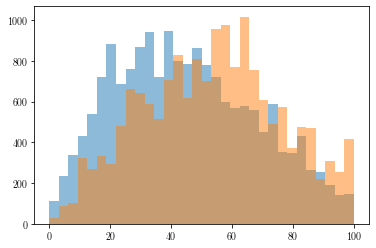

In [31]:
_=plt.hist(sess_err, bins=np.linspace(0,100,33), alpha=0.5)
_=plt.hist(sess_err_belief, bins=np.linspace(0,100,33), alpha=0.5)

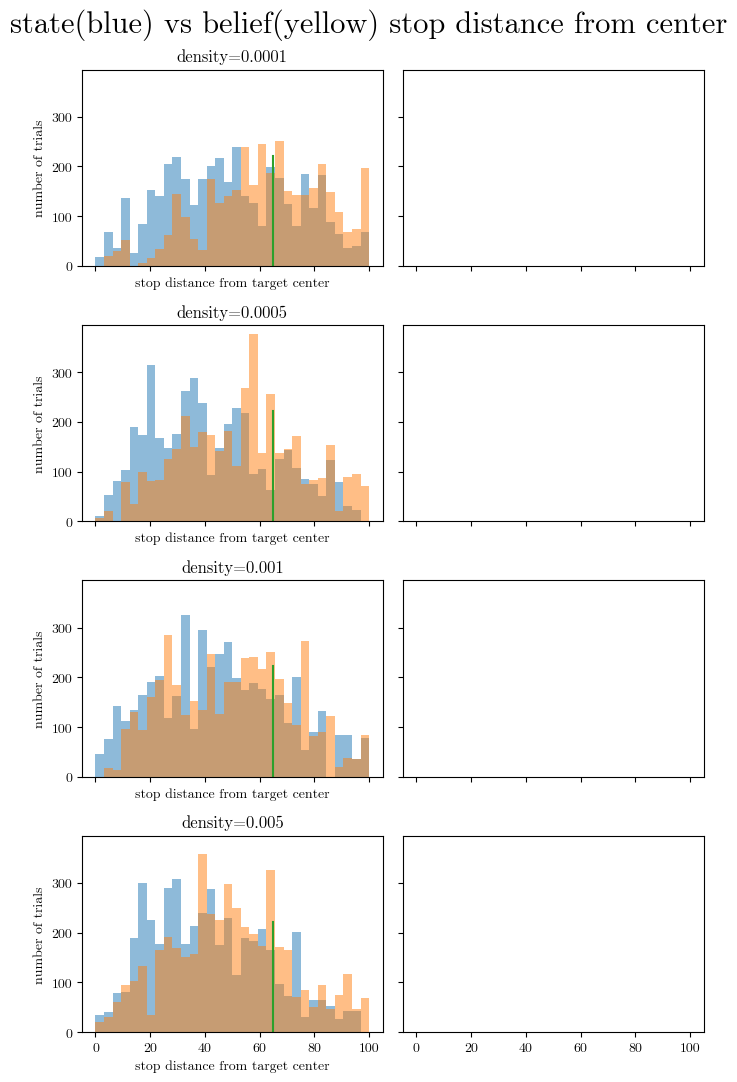

In [32]:
fig,axs=plt.subplots(4,2, figsize=(7,11), dpi=100,sharey=True,sharex=True,)
for i, den in enumerate([0.0001, 0.0005, 0.001,  0.005]):
    mask=(dens_t==den)

    ax=axs[i,0]
    _=ax.hist(sess_err[mask], bins=np.linspace(0,100,33), alpha=0.5)
    _=ax.hist(sess_err_belief[mask], bins=np.linspace(0,100,33), alpha=0.5)
    ax.plot([65,65],[0,222])
    # c=ax.scatter(sess_latentff_hori[mask], sess_latentb_hori[mask], c=sess_ll_t[mask],s=1, cmap='jet', vmax=44, alpha=0.3)
    # ax.plot([-50,50],[-50,50],'k')
    # ax.plot([-0,0],[-66,66],'k')
    ax.set_title(f'density={den}')
    ax.set_xlabel('stop distance from target center')
    ax.set_ylabel('number of trials')
    # fig.colorbar(c, ax=ax, label='negative log likelihood')

plt.suptitle('state(blue) vs belief(yellow) stop distance from center', fontsize=22)
plt.tight_layout()
plt.show()




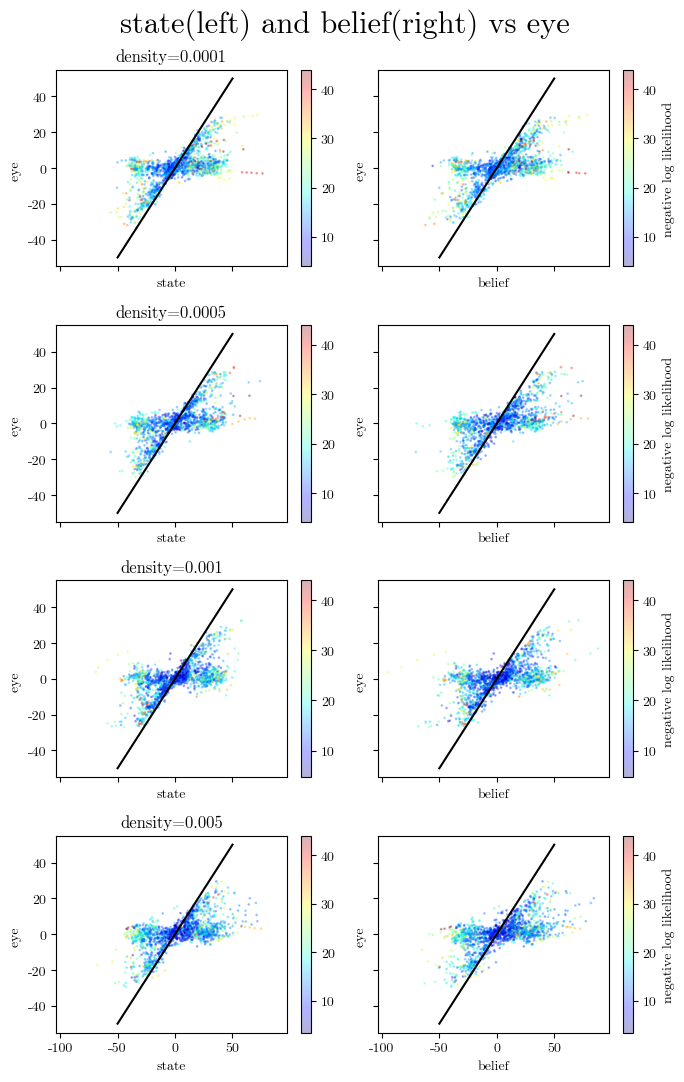

In [33]:
fig,axs=plt.subplots(4,2, figsize=(7,11), dpi=100,sharey=True,sharex=True,)
for i, den in enumerate([0.0001, 0.0005, 0.001,  0.005]):
    mask=(dens_t==den)&(sess_t<5)

    ax=axs[i,0]
    c=ax.scatter(sess_latentff_hori[mask], sess_eye_hori[mask], c=sess_ll_t[mask], s=1, alpha=0.3, cmap='jet', vmax=44)
    ax.set_title(f'density={den}')
    ax.plot([-50,50],[-50,50],'k')
    fig.colorbar(c, ax=ax)
    ax.set_xlabel('state')
    ax.set_ylabel('eye ')
    ax=axs[i,1]
    c=ax.scatter(sess_latentb_hori[mask], sess_eye_hori[mask], c=sess_ll_t[mask], s=1, alpha=0.3, cmap='jet', vmax=44)
    fig.colorbar(c, ax=ax, label='negative log likelihood')
    # ax.set_title('belief vs eye hori')
    ax.plot([-50,50],[-50,50],'k')
    ax.set_xlabel('belief')
    ax.set_ylabel('eye ')

plt.suptitle('state(left) and belief(right) vs eye', fontsize=22)
plt.tight_layout()
plt.show()

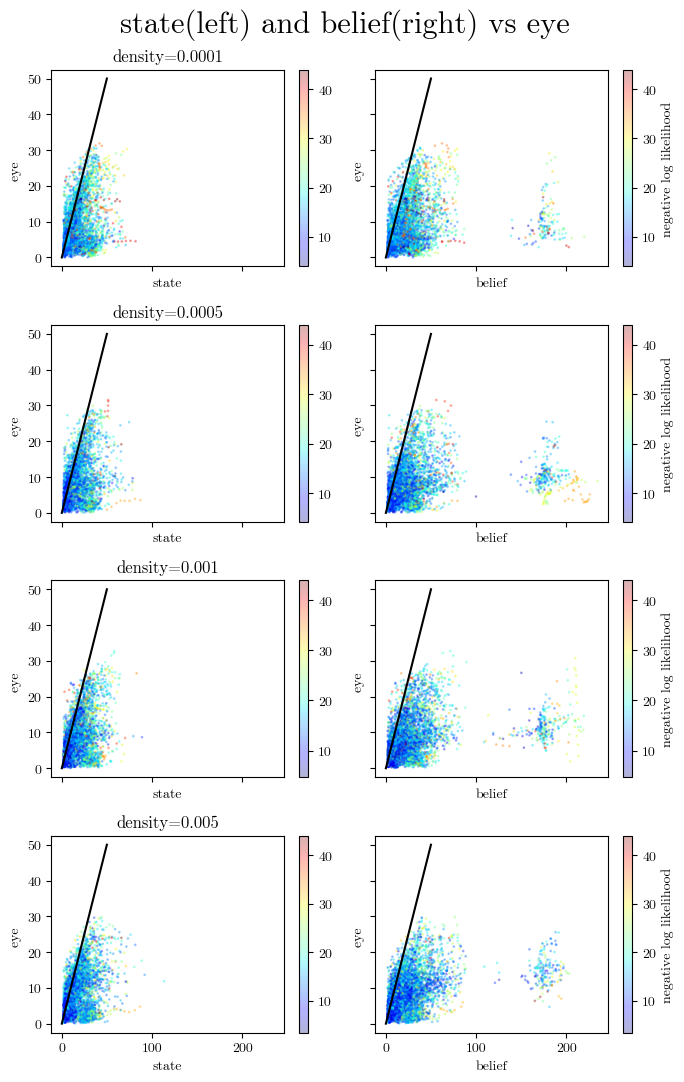

In [34]:
fig,axs=plt.subplots(4,2, figsize=(7,11), dpi=100,sharey=True,sharex=True,)
for i, den in enumerate([0.0001, 0.0005, 0.001,  0.005]):
    mask=(dens_t==den)

    ax=axs[i,0]
    c=ax.scatter(distance(sess_latentff_hori,sess_latentff_vert)[mask],distance(sess_eye_hori,sess_eye_vert)[mask], c=sess_ll_t[mask], s=1, alpha=0.3, cmap='jet', vmax=44)
    ax.set_title(f'density={den}')
    ax.plot([-0,50],[-0,50],'k')
    fig.colorbar(c, ax=ax)
    ax.set_xlabel('state')
    ax.set_ylabel('eye ')
    ax=axs[i,1]

    c=ax.scatter(distance(sess_latentb_hori,sess_latentb_vert)[mask],distance(sess_eye_hori,sess_eye_vert)[mask], c=sess_ll_t[mask], s=1, alpha=0.3, cmap='jet', vmax=44)
    fig.colorbar(c, ax=ax, label='negative log likelihood')
    # ax.set_title('belief vs eye hori')
    ax.plot([-0,50],[-0,50],'k')
    ax.set_xlabel('belief')
    ax.set_ylabel('eye ')

plt.suptitle('state(left) and belief(right) vs eye', fontsize=22)
plt.tight_layout()
plt.show()




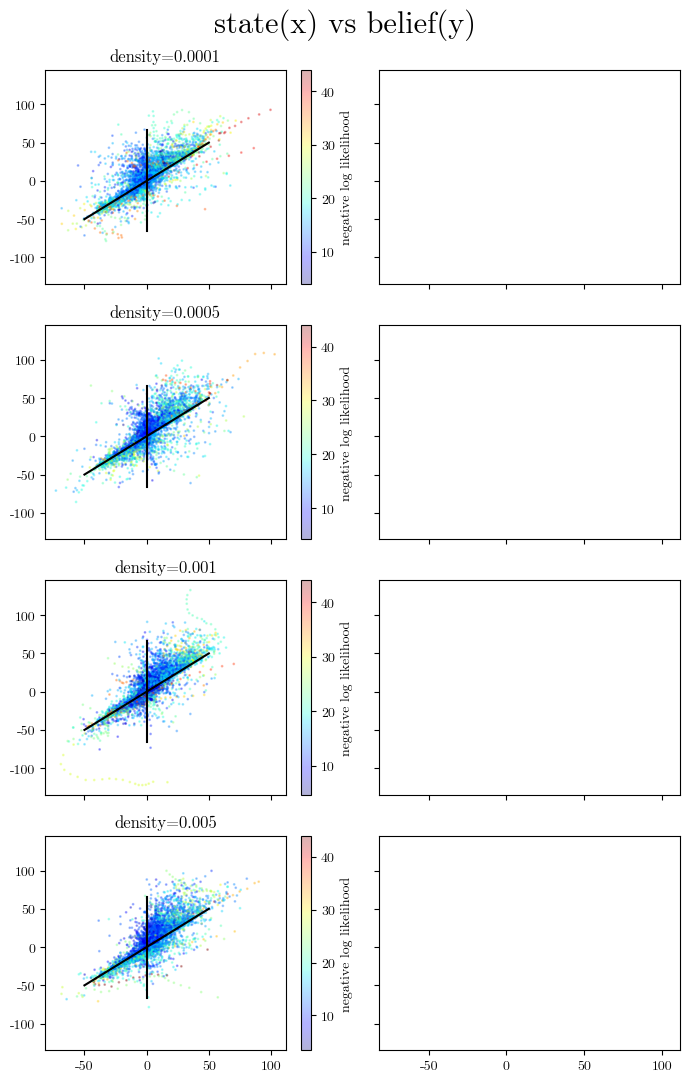

In [35]:
fig,axs=plt.subplots(4,2, figsize=(7,11), dpi=100,sharey=True,sharex=True,)
for i, den in enumerate([0.0001, 0.0005, 0.001,  0.005]):
    mask=(dens_t==den)

    ax=axs[i,0]
    c=ax.scatter(sess_latentff_hori[mask], sess_latentb_hori[mask], c=sess_ll_t[mask],s=1, cmap='jet', vmax=44, alpha=0.3)
    ax.plot([-50,50],[-50,50],'k')
    ax.plot([-0,0],[-66,66],'k')
    ax.set_title(f'density={den}')
    fig.colorbar(c, ax=ax, label='negative log likelihood')

plt.suptitle('state(x) vs belief(y)', fontsize=22)
plt.tight_layout()
plt.show()




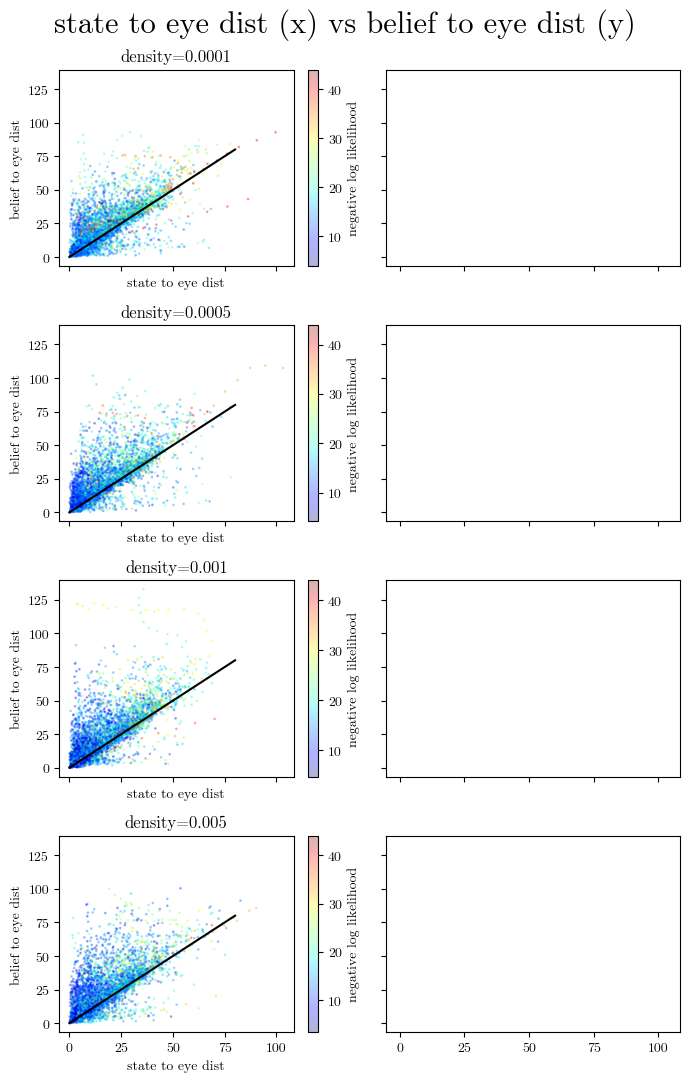

In [36]:
fig,axs=plt.subplots(4,2, figsize=(7,11), dpi=100,sharey=True,sharex=True,)
for i, den in enumerate([0.0001, 0.0005, 0.001,  0.005]):
    mask=(dens_t==den)
    ax=axs[i,0]

    bd, sd=distance(sess_latentb_hori, sess_eye_hori),distance(sess_latentff_hori, 
    sess_eye_hori)
    c=ax.scatter(sd[mask],bd[mask],c=sess_ll_t[mask], s=1,alpha=0.3, cmap='jet', vmax=44)
    # ax.set_title('belief vs state to eye dist hori')
    ax.plot([-0,80],[-0,80],'k')
    fig.colorbar(c, ax=ax, label='negative log likelihood')
    ax.set_xlabel('state to eye dist')
    ax.set_ylabel('belief to eye dist')
    ax.set_title(f'density={den}')


plt.suptitle('state to eye dist (x) vs belief to eye dist (y)', fontsize=22)
plt.tight_layout()
plt.show()


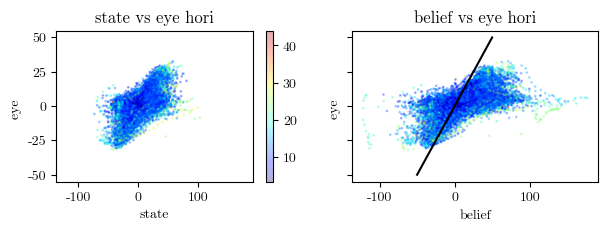

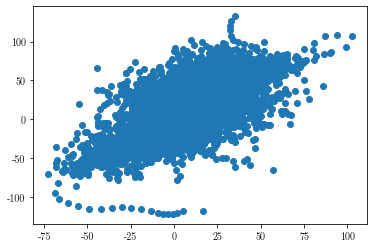

In [37]:
mask=np.ones_like(sess_t).astype('bool')
fig,axs=plt.subplots(1,2, figsize=(7,2), dpi=100,sharey=True,sharex=True,)
ax=axs[0]
ax.scatter(sess_latentff_hori[mask], sess_eye_hori[mask], c=sess_ll_t[mask], s=1, alpha=0.3, cmap='jet')
ax.set_title('state vs eye hori')
# ax.plot([-50,50],[-50,50],'k')
fig.colorbar(c, ax=ax)
ax.set_xlabel('state')
ax.set_ylabel('eye ')
ax=axs[1]
c=ax.scatter(sess_latentb_hori[mask], sess_eye_hori[mask], c=sess_ll_t[mask], s=1, alpha=0.3, cmap='jet')
# fig.colorbar(c, ax=ax)
ax.set_title('belief vs eye hori')
ax.plot([-50,50],[-50,50],'k')
ax.set_xlabel('belief')
ax.set_ylabel('eye ')
plt.show()
plt.scatter(sess_latentff_hori, sess_latentb_hori)

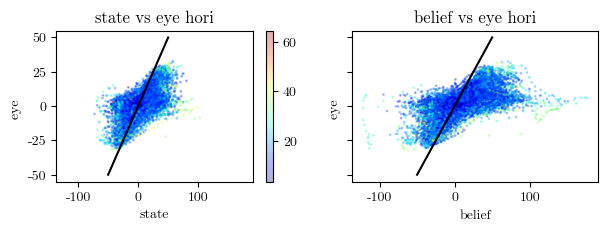

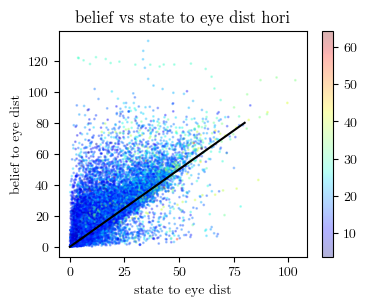

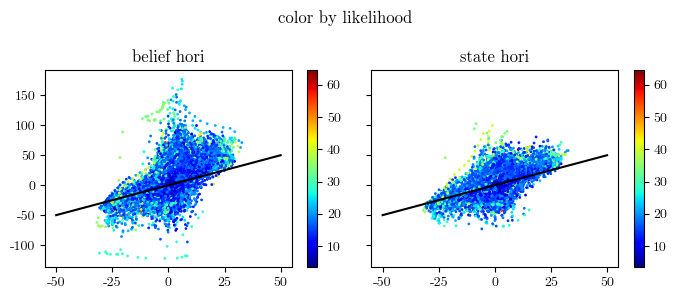

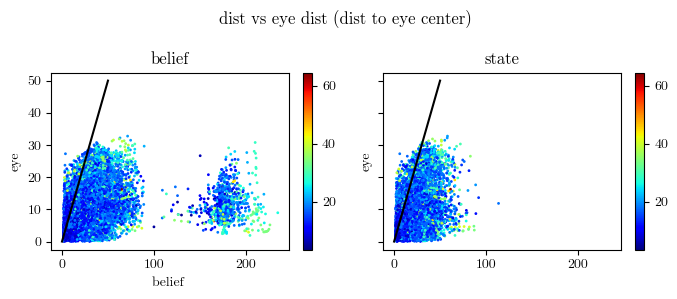

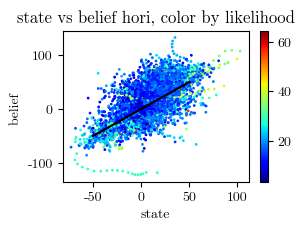

In [38]:
# mask the data 

# 
# mask=(sess_t<5)
# mask=(sess_err>65)
# mask=(sess_err_belief>65)
# mask=(sess_ll_t<20)
mask=np.ones_like(sess_t).astype('bool')

# mask=(dens_t==[0.0001, 0.0005, 0.001,  0.005][0])

fig,axs=plt.subplots(1,2, figsize=(7,2), dpi=100,sharey=True,sharex=True,)
ax=axs[0]
ax.scatter(sess_latentff_hori[mask], sess_eye_hori[mask], c=sess_ll_t[mask], s=1, alpha=0.3, cmap='jet')
ax.set_title('state vs eye hori')
ax.plot([-50,50],[-50,50],'k')
fig.colorbar(c, ax=ax)
ax.set_xlabel('state')
ax.set_ylabel('eye ')
ax=axs[1]
c=ax.scatter(sess_latentb_hori[mask], sess_eye_hori[mask], c=sess_ll_t[mask], s=1, alpha=0.3, cmap='jet')
# fig.colorbar(c, ax=ax)
ax.set_title('belief vs eye hori')
ax.plot([-50,50],[-50,50],'k')
ax.set_xlabel('belief')
ax.set_ylabel('eye ')
plt.show()


fig,axs=plt.subplots(1,1, sharey=True,sharex=True, figsize=(4,3),dpi=100)
bd, sd=distance(sess_latentb_hori, sess_eye_hori),distance(sess_latentff_hori, 
sess_eye_hori)
c=plt.scatter(sd[mask],bd[mask],c=sess_ll_t[mask], s=1,alpha=0.3, cmap='jet')
plt.title('belief vs state to eye dist hori')
plt.plot([-0,80],[-0,80],'k')
fig.colorbar(c, ax=axs)
plt.xlabel('state to eye dist')
plt.ylabel('belief to eye dist')
plt.show()


fig,axs=plt.subplots(1,2, sharey=True,sharex=True, figsize=(7,3),dpi=100)
ax=axs[0]
c=ax.scatter(sess_eye_hori[mask], sess_latentb_hori[mask], c=sess_ll_t[mask],s=1, cmap='jet')
ax.plot([-50,50],[-50,50],'k')
ax.set_title('belief hori')
fig.colorbar(c, ax=ax)
ax=axs[1]
c=ax.scatter(sess_eye_hori[mask], sess_latentff_hori[mask], c=sess_ll_t[mask],s=1, cmap='jet')
ax.plot([-50,50],[-50,50],'k')
ax.set_title('state hori')
fig.colorbar(c, ax=ax)
plt.suptitle('color by likelihood')
plt.tight_layout()
plt.show()

fig,axs=plt.subplots(1,2, sharex=True,sharey=True, figsize=(7,3),dpi=100)
ax=axs[0]
c=ax.scatter(distance(sess_latentb_hori,sess_latentb_vert)[mask],distance(sess_eye_hori,sess_eye_vert)[mask], c=sess_ll_t[mask],s=1, cmap='jet')
ax.plot([-0,50],[-0,50],'k')
fig.colorbar(c, ax=ax)
ax.set_title('belief')
ax.set_xlabel('belief ')
ax.set_ylabel('eye')
ax=axs[1]
c=ax.scatter(distance(sess_latentff_hori,sess_latentff_vert)[mask],distance(sess_eye_hori,sess_eye_vert)[mask], c=sess_ll_t[mask],s=1, cmap='jet')
ax.plot([-0,50],[-0,50],'k')
fig.colorbar(c, ax=ax)
ax.set_title('state')
plt.ylabel('eye')
ax.set_title('state')
plt.suptitle( 'dist vs eye dist (dist to eye center)')
plt.tight_layout()
plt.show()


fig,axs=plt.subplots(1,1, figsize=(3,2), dpi=100)
c=plt.scatter(sess_latentff_hori[mask], sess_latentb_hori[mask], c=sess_ll_t[mask],s=1, cmap='jet')
plt.plot([-50,50],[-50,50],'k')
plt.title('state vs belief hori, color by likelihood')
ax=plt.gca()
ax.set_xlabel('state')
ax.set_ylabel('belief ')
plt.colorbar(c)
plt.show()



In [39]:
len(sess_angle_from_start_belief), len(sess_latentb_hori)

(18985, 18985)

In [40]:
def svb(thisx, thisb, thisy, thisc,mask, xlabel='x', ylabel='y'):
    fig,axs=plt.subplots(1,2, figsize=(6,2), dpi=100, sharex=True, sharey=True)
    ax=axs[0]
    c=ax.scatter(thisx[mask], thisy[mask], c=thisc[mask], s=1, cmap='jet')
    # ax=plt.gca()
    ax.set_xlabel(f'state {xlabel}')
    ax.set_ylabel(ylabel)
    ax.set_title(f' pearson r = {pearsonr(thisx[mask], thisy[mask])[0]:.2f}')
    # fig.colorbar(c)
    # plt.xlim(0,3.15)
    # plt.show()

    # fig,axs=plt.subplots(1,1, figsize=(3,2), dpi=100)
    
    ax=axs[1]
    c=ax.scatter(thisb[mask], thisy[mask], c=thisc[mask], s=1, cmap='jet')
    ax.set_xlabel(f'belief {xlabel}')
    ax.set_ylabel(ylabel)
    ax.set_title(f' pearson r = {pearsonr(thisb[mask], thisy[mask])[0]:.2f}')
    fig.colorbar(c, label='negative log liklihood')
    # plt.xlim(0, 3.15)
    plt.show()

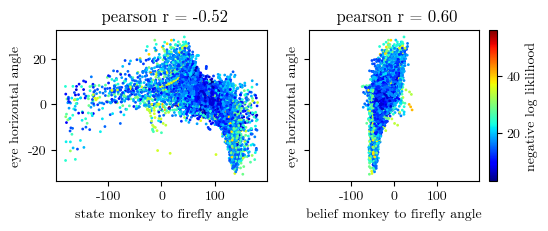

In [41]:
# use the f-m angle, t
mask=(sess_t>5)

# mask=~np.isnan(sess_t)
thisx=np.rad2deg(state_angle_f)
thisb=np.rad2deg(belief_angle_f)
thisy=sess_eye_hori
thisc=sess_ll_t
svb(thisx, thisb, thisy, thisc,mask, xlabel='monkey to firefly angle', ylabel='eye horizontal angle')

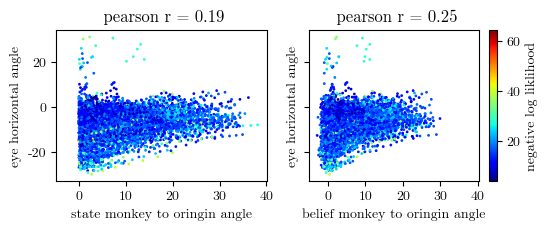

In [42]:
# use the m-o angle
mask=(sess_t>4)&(state_angle>0)
thisx=np.rad2deg(state_angle)
thisb=np.rad2deg(belief_angle)
thisy=-sess_eye_hori
thisc=sess_ll_t
svb(thisx, thisb, thisy, thisc,mask, xlabel='monkey to oringin angle', ylabel='eye horizontal angle')

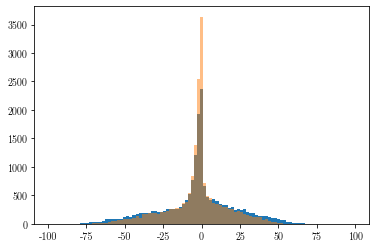

In [43]:
bins=np.linspace(-99,99,100)
_=plt.hist((state_heading), bins=bins)
_=plt.hist(np.rad2deg(belief_heading), bins=bins, alpha=0.5)

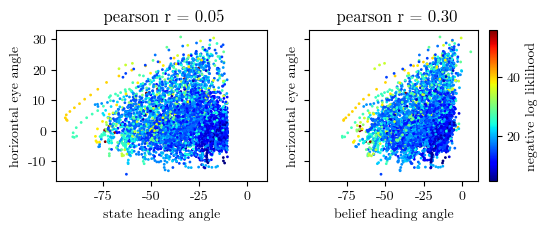

In [44]:
# use the heading angle
mask=((state_heading<-10)|(state_heading<-10)) &(sess_t>5)
thisx=(state_heading)
thisb=np.rad2deg(belief_heading)
thisy=-sess_eye_hori
thisc=sess_ll_t
svb(thisx, thisb, thisy, thisc,mask, xlabel='heading angle', ylabel='horizontal eye angle')

### neural to heading direction

In [45]:
belief_heading.shape, r_ppc_t.shape

from sklearn.datasets import make_regression
from sklearn.model_selection import KFold
from sklearn.linear_model import LassoCV, Lasso
from sklearn.metrics import mean_squared_error
import numpy as np

def lasso_wrap(X, y, num_folds=5,title='title'):
    # Initialize k-fold cross-validation
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

    # Initialize LassoCV model
    lasso_cv = LassoCV(cv=kf, random_state=42)

    # Lists to store scores and best alphas from each fold
    scores = []
    best_alphas = []

    # Perform k-fold cross-validation
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        lasso_cv.fit(X_train, y_train)

        best_alpha = lasso_cv.alpha_
        best_alphas.append(best_alpha)

        predictions = lasso_cv.predict(X_test)
        mse = mean_squared_error(y_test, predictions)
        scores.append(mse)



    # Calculate the average score and best alpha across folds
    avg_score = np.mean(scores)
    avg_alpha = np.mean(best_alphas)

    fig,ax=plt.subplots(1,1)
    lasso=Lasso(alpha=avg_alpha)
    lasso.fit(X, y)
    predictions=lasso.predict(X)
    predvstrue_scatter(predictions, y, ax,size=5)
    ax.set_title(f'{title}, {num_folds} folds cv mse = {avg_score:.2f}')
    ax.plot(ax.get_xlim(),ax.get_xlim(),'k')
    ax.set_xlabel('angle degree')
    ax.set_ylabel('angle degree')

    print(f"Average Mean Squared Error across {num_folds} folds: {avg_score}")
    print(f"Average Best alpha across {num_folds} folds: {avg_alpha}")



Average Mean Squared Error across 5 folds: 245.15707686078682
Average Best alpha across 5 folds: 0.0030328814339006544
Average Mean Squared Error across 5 folds: 186.80233950231786
Average Best alpha across 5 folds: 0.0025764088365416633


ValueError: Found input variables with inconsistent numbers of samples: [5933, 18985]

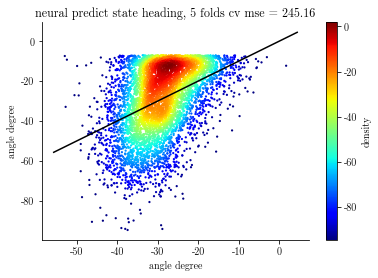

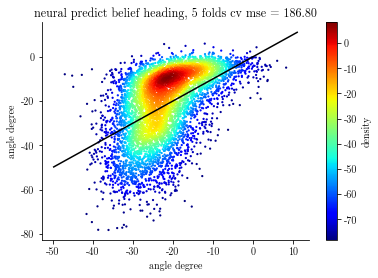

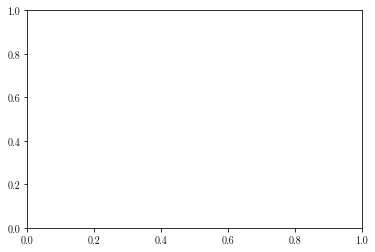

In [46]:
mask=(state_heading<-7) &(sess_t>0)
thiss=state_heading[mask]
thisb=np.rad2deg(belief_heading)[mask]
thise=-sess_eye_hori
thisx=r_ppc_t[mask]

lasso_wrap(thisx, thiss, title='neural predict state heading')
lasso_wrap(thisx, thisb, title='neural predict belief heading')
lasso_wrap(thisx, thise, title='neural predict eye direction')

In [47]:
[a.shape for a in[ thisx, thisb, thisy, thisc]]

[(18985,), (18985,), (18985,), (18985,)]

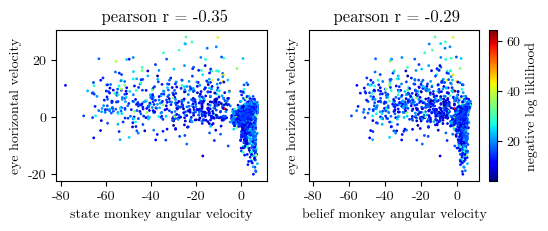

In [47]:
# use the heading angle diff
mask=(state_heading>5)[:-1]
thisx=np.diff(state_heading)
thisb=np.diff(np.rad2deg(belief_heading))
thisy=np.diff(-sess_eye_hori)
thisc=sess_ll_t[:-1]
svb(thisx, thisb, thisy, thisc,mask, xlabel='monkey angular velocity', ylabel='eye horizontal velocity')

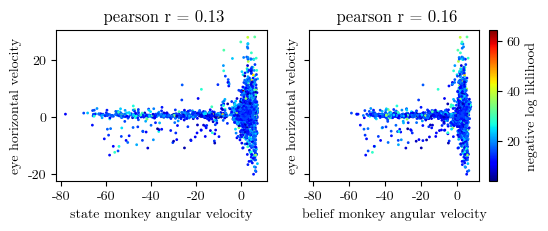

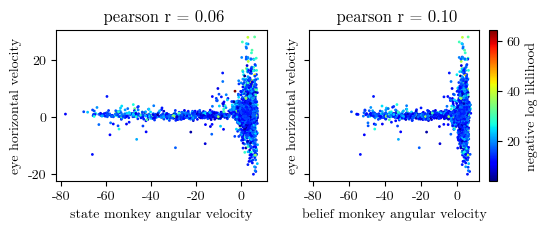

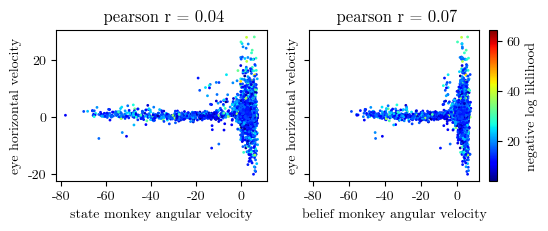

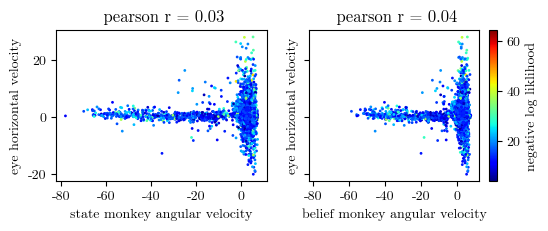

In [48]:
# sliding window 
for sliding_dt in np.arange(1,5):
    mask=(state_heading>5)[:-1]
    thisx=np.diff(state_heading)[mask][sliding_dt:]
    thisb=np.diff(np.rad2deg(belief_heading))
    thisy=np.diff(-sess_eye_hori)
    thisc=sess_ll_t[:-1]

    # use future heading vs current eye (eye look at future)
    # thisx=thisx
    thisb=np.diff(np.rad2deg(belief_heading))[mask][sliding_dt:]
    thisy=thisy[mask][:-sliding_dt]
    thisc=thisc[mask][:-sliding_dt]
    mask=np.ones_like(thisx).astype('bool')

    svb(thisx, thisb, thisy, thisc, mask, xlabel='monkey angular velocity', ylabel='eye horizontal velocity')

In [49]:
state_stop_angle[mask.astype('bool')]
# , eye_hori[mask], c=sess_ll_t[mask]

IndexError: boolean index did not match indexed array along dimension 0; dimension is 1252 but corresponding boolean dimension is 18984

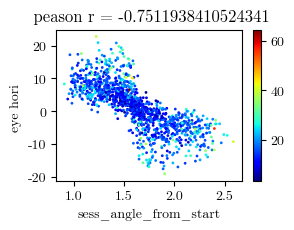

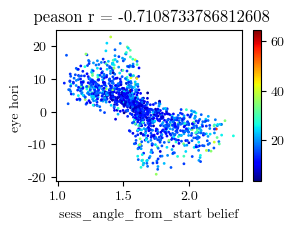

In [50]:
# stop angle.

state_stop_angle=[]; belief_stop_angle=[]; eye_stop_hori=[]
for itrial in range(len(trial_idces)):
    (rel_dist, rel_ang, abs_dist, abs_ang,
                                    eye_hor_theta, eye_ver_theta, latent_ff_hori, latent_ff_vert,
                                    fx, fy, mx, my, mv, mw)=zip(*yy[itrial])
    state_stop_angle.append(np.arctan2(my[-1]-my[0], mx[-1]-mx[0]))
    eye_stop_hori.append(np.mean(eye_hor_theta))
for ep_beliefs, ep_covs, task in zip(beliefs, covs, tasks):
    mx, my, body_theta,  mv,mw= zip(*ep_beliefs)
    fx,fy=task[0]*worldscale, task[1]*worldscale
    mx, my = np.asarray(my).reshape(-1).astype('float')*worldscale, np.asarray(mx).reshape(-1).astype('float')*worldscale
    belief_stop_angle.append(np.arctan2(my[-1]-my[0], mx[-1]-mx[0]))

sess_ll=np.array(sess_ll)
eye_stop_hori=np.array(eye_stop_hori)
state_stop_angle=np.array(state_stop_angle)
belief_stop_angle=np.array(belief_stop_angle)
state_belief_diff_stop_angle=np.abs(state_stop_angle-belief_stop_angle)
# plotting mask
mask=np.argsort(state_belief_diff_stop_angle)[::-1][:len(state_belief_diff_stop_angle)//2]
mask=np.ones_like(state_belief_diff_stop_angle).astype('bool')

fig,axs=plt.subplots(1,1, figsize=(3,2), dpi=100)
c=plt.scatter(state_stop_angle[mask], eye_stop_hori[mask], c=sess_ll[mask], s=1, cmap='jet')
ax=plt.gca()
ax.set_xlabel('sess_angle_from_start')
ax.set_ylabel('eye hori ')
plt.title(f' peason r = {pearsonr(state_stop_angle[mask], eye_stop_hori[mask])[0]}')
plt.colorbar(c)
plt.show()

fig,axs=plt.subplots(1,1, figsize=(3,2), dpi=100)
c=plt.scatter(belief_stop_angle[mask], eye_stop_hori[mask], c=sess_ll[mask], s=1, cmap='jet')
ax=plt.gca()
ax.set_xlabel('sess_angle_from_start belief')
ax.set_ylabel('eye hori ')
plt.title(f' peason r = {pearsonr(belief_stop_angle[mask], eye_stop_hori[mask])[0]}')
plt.colorbar(c)
plt.show()

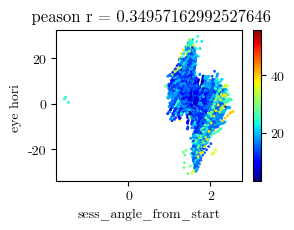

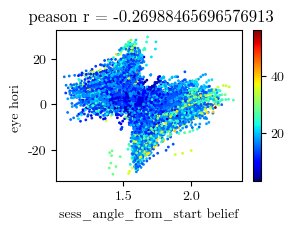

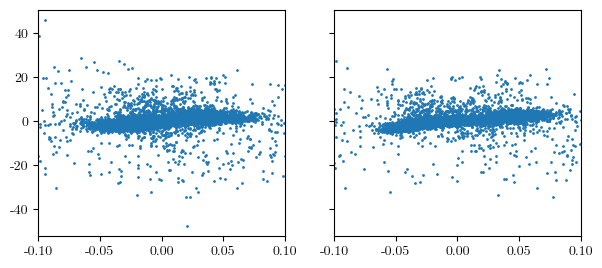

In [51]:
# 1127 test
mask=np.ones_like(sess_t).astype('bool')
mask=(sess_t>5)
# mask=np.array(sess_t_end)-1
from scipy.stats import pearsonr
sess_ll_t=np.array(sess_ll_t)
fig,axs=plt.subplots(1,1, figsize=(3,2), dpi=100)
c=plt.scatter(sess_angle_from_start[mask], sess_eye_hori[mask], c=sess_ll_t[mask], s=1, cmap='jet')
# plt.plot([-50,50],[-50,50],'k')
# plt.title('state vs belief hori, color by likelihood')
ax=plt.gca()
ax.set_xlabel('sess_angle_from_start')
ax.set_ylabel('eye hori ')
plt.title(f' peason r = {pearsonr(-sess_angle_from_start[mask], sess_eye_hori[mask])[0]}')
plt.colorbar(c)
plt.show()

fig,axs=plt.subplots(1,1, figsize=(3,2), dpi=100)
c=plt.scatter(sess_angle_from_start_belief[mask], sess_eye_hori[mask], c=sess_ll_t[mask], s=1, cmap='jet')
# plt.plot([-50,50],[-50,50],'k')
# plt.title('state vs belief hori, color by likelihood')
ax=plt.gca()
ax.set_xlabel('sess_angle_from_start belief')
ax.set_ylabel('eye hori ')
plt.title(f' peason r = {pearsonr(sess_angle_from_start_belief[mask], sess_eye_hori[mask])[0]}')
plt.colorbar(c)
plt.show()


fig,axs=plt.subplots(1,2, figsize=(7,3), dpi=100, sharex=True, sharey=True)
ax=axs[0]
c=ax.scatter(np.diff(sess_angle_from_start_belief[mask]), np.diff(sess_eye_hori[mask]), s=1, cmap='jet')

ax=axs[1]
c=ax.scatter(np.diff(sess_angle_from_start[mask]), np.diff(sess_eye_hori[mask]), s=1, cmap='jet')
ax.set_xlim(-0.1,0.1)
plt.show()

In [53]:
# check belief reward vs state reward
cutoff=99 # the threshold for likelihood in histogram

belief_radial_err=[]
state_radial_err=[]
success_inds=[]
for ep_beliefs, ep_covs, task in zip(beliefs, covs,tasks):
    mx, my, body_theta,  mv,mw= zip(*ep_beliefs)
    mx,my=mx[-1],my[-1]
    epbelief_radial_err= ((mx-task[0])**2+(my-task[1])**2)**0.5
    belief_radial_err.append(epbelief_radial_err.item())

for i, (ep_states, ep_covs, task) in enumerate(zip(states, covs,tasks)):
    mx, my, body_theta,  mv,mw= zip(*ep_states)
    mx,my=mx[-1],my[-1]
    ep_states_radial_err= ((mx-task[0])**2+(my-task[1])**2)**0.5
    state_radial_err.append(ep_states_radial_err.item())
    if ep_states_radial_err.item()<0.13: success_inds.append(i)
state_radial_err, belief_radial_err=np.array(state_radial_err), np.array(belief_radial_err)


# plot by likelihood cutoof
sortinds=np.argsort(sessionll)
_=plt.hist(state_radial_err[sortinds[:cutoff]], bins=np.linspace(0,1,50))
plt.title(f'state radial err {sum(state_radial_err[sortinds[:cutoff]])/cutoff}')
plt.xlabel('trial stop radial error [1 m]');plt.ylabel('number of trials')
# plt.show()
_=plt.hist(belief_radial_err[sortinds[:222]],bins=np.linspace(0,1,50))
plt.title(f'belief radial err {sum(belief_radial_err[sortinds[:cutoff]])/cutoff}')
plt.xlabel('trial stop radial error [1 m]');plt.ylabel('number of trials')
plt.show()
# plt.scatter(state_radial_err, sessionll, s=4)
# plt.scatter(belief_radial_err, sessionll, s=4)
# plt.xlim(0,1)

# plot by success_inds
a=plt.hist(np.array(sessionll), bins=np.linspace(0,100,50))
b=plt.hist(np.array(sessionll)[success_inds], bins=np.linspace(0,100,50), label='correct')
plt.title(f'trial negative likelihood by sucecss and failure')
plt.xlabel('trial negative liklihood');plt.ylabel('number of trials')
plt.legend()
plt.show()


v1,v2=a[0], b[0]
plt.bar(np.linspace(0,100,49),v2/v1)
plt.title(f'trial negative likelihood by percentage correct')
plt.xlabel('trial negative liklihood');plt.ylabel('percent correct')
plt.legend()
plt.show()


NameError: name 'sessionll' is not defined

### convert to relative xy coord

In [55]:
relative_beliefs=[]
relative_covs=[]

for ep_beliefs, ep_covs, task in zip(beliefs, covs,tasks):
    mx, my, body_theta,  mv,mw= zip(*ep_beliefs)
    mx, my, body_theta,  mv,mw = np.array(torch.tensor(mx)), np.array(torch.tensor(my)), np.array(torch.tensor(body_theta)), np.array(torch.tensor(mv)), np.array(torch.tensor(mw))
    rel_lat, rel_for=convert_location_to_relative(
                            mx,
                            my,
                            body_theta,
                            task[0],
                            task[1])    
    relative_beliefs.append(np.stack([rel_lat, rel_for]).T)
    rotdegree=body_theta+180
    relativeposcov_=[]
    for degree, thiscov in zip(rotdegree, ep_covs):
        R=np.array([[np.cos(-degree/180*pi),-np.sin(-degree/180*pi)],[np.sin(-degree/180*pi),np.cos(-degree/180*pi)]])
        relativeposcov_.append(R.T@np.array(thiscov)[:2,:2]@R)
    relativeposcov_=np.stack(relativeposcov_)
    relative_covs.append(relativeposcov_)

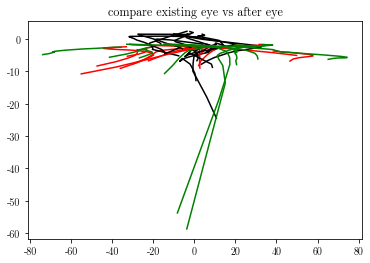

In [56]:
# sanity chekc and test-------------

# for ep_beliefs, ep_covs, task in zip(beliefs[:21], covs[:21],tasks[:21]):
#     mx, my, body_theta,  mv,mw= zip(*ep_beliefs)
#     plt.plot(mx,my)
# plt.title('belief')
# plt.show()

# for i in range(21):
#     # y downsample, raw data
#     rel_dist, rel_ang, abs_dist, abs_ang,hor_theta, ver_theta, hor_theta_, ver_theta_,fx, fy, mx, my, mv, mw=zip(*eval(m)[f'{key}Ydownsampled'][i][1])
#     plt.plot(mx,my)
#     # plt.plot(-np.deg2rad(np.cumsum(mw) * 0.1 -90))
# plt.title('states')
# plt.show()


for i in range(0,11):
    # y downsample, raw data
    rel_dist, rel_ang, abs_dist, abs_ang,hor_theta, ver_theta, hor_theta_, ver_theta_,fx, fy, mx, my, mv, mw=zip(*eval(m)[f'{key}Ydownsampled'][i][1])
    # plt.plot(hor_theta_, ver_theta_, 'k')
    body_theta = -np.deg2rad(np.cumsum(mw) * 0.1 -90)
    body_x, body_y = np.array(mx).reshape(-1), np.array(my).reshape(-1)

    hor_theta_, ver_theta_ = convert_location_to_angle(abs(np.array(rel_dist)).reshape(-1), np.array(fx).reshape(-1), np.array(fy).reshape(-1),
                body_theta, body_x, body_y, 
                            np.array(hor_theta).reshape(-1), np.array(ver_theta).reshape(-1),DT=0.1, remove_pre=False)
    plt.plot(hor_theta_, ver_theta_, 'r')

    plt.plot(hor_theta, ver_theta, 'k')
    # plt.plot(abs(np.array(rel_dist)).reshape(-1) , 'r')

plt.title('compare existing eye vs after eye')
# plt.show()


# belief eye compare to state eye (shoudl be similar)
for ep_beliefs, ep_covs, task in zip(beliefs[:11], covs[:11],tasks[:11]):
    mx, my, body_theta,  mv,mw= zip(*ep_beliefs)
    body_theta = -(np.cumsum(mw) * 0.1-pi/2)
    body_x, body_y = np.asarray(my).reshape(-1).astype('float')*worldscale, np.asarray(mx).reshape(-1).astype('float')*worldscale
    # plt.plot(body_theta,'k')

    fx, fy=task[1]*worldscale, task[0]*worldscale
    rel_dist = ((fx-body_x)**2+(fy-body_y)**2)**0.5
    hor_theta_, ver_theta_ = convert_location_to_angle(abs(np.array(rel_dist)).reshape(-1).astype('float'), np.array(fx).reshape(-1).astype('float'), np.array(fy).reshape(-1).astype('float'),
                body_theta.astype('float'), body_x.astype('float'), body_y.astype('float'), 
                np.array(hor_theta).reshape(-1).astype('float'), np.array(ver_theta).reshape(-1).astype('float'), DT=0.1,remove_pre=False)
    plt.plot(hor_theta_, ver_theta_, 'g')
    # plt.plot(hor_theta, ver_theta, 'g')
    # plt.plot(fx*worldscale, fy*worldscale , 'g')
    # plt.plot(abs(np.array(rel_dist)).reshape(-1),'k')
plt.title('compare existing eye vs after eye')
plt.show()


### convert to eye coord

In [49]:
# belief eye compare to state eye (shoudl be similar)
for ep_beliefs, ep_covs, task in zip(beliefs[:11], covs[:11],tasks[:11]):
    mx, my, body_theta,  mv,mw= zip(*ep_beliefs)
    body_theta = -(np.cumsum(mw) * 0.1-pi/2)
    body_x, body_y = np.asarray(my).reshape(-1).astype('float')*worldscale, np.asarray(mx).reshape(-1).astype('float')*worldscale
    # plt.plot(body_theta,'k')

    fx, fy=task[1]*worldscale, task[0]*worldscale
    rel_dist = ((fx-body_x)**2+(fy-body_y)**2)**0.5
    hor_theta_, ver_theta_ = convert_location_to_angle(abs(np.array(rel_dist)).reshape(-1).astype('float'), np.array(fx).reshape(-1).astype('float'), np.array(fy).reshape(-1).astype('float'),
                body_theta.astype('float'), body_x.astype('float'), body_y.astype('float'), 
                np.array(hor_theta).reshape(-1).astype('float'), np.array(ver_theta).reshape(-1).astype('float'), DT=0.1,remove_pre=False)
    plt.plot(hor_theta_, ver_theta_, 'g')
    # plt.plot(hor_theta, ver_theta, 'g')
    # plt.plot(fx*worldscale, fy*worldscale , 'g')
    # plt.plot(abs(np.array(rel_dist)).reshape(-1),'k')

plt.show()

NameError: name 'hor_theta' is not defined

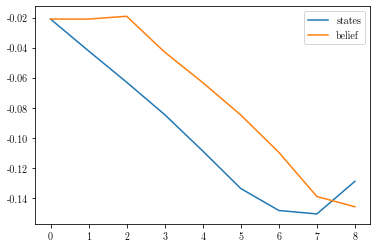

In [58]:
i+=1
mx, my, body_theta,  mv,mw= zip(*states[i])
mx, my, body_theta,  mv,mw = np.array(torch.tensor(mx)), np.array(torch.tensor(my)), np.array(torch.tensor(body_theta)), np.array(torch.tensor(mv)), np.array(torch.tensor(mw))
plt.plot(body_theta, label='states')
# beliefs
ep_beliefs, ep_covs, task =beliefs[i], covs[i],tasks[i]
mx, my, body_theta,  mv,mw= zip(*ep_beliefs)
mx, my, body_theta,  mv,mw = np.array(torch.tensor(mx)), np.array(torch.tensor(my)), np.array(torch.tensor(body_theta)), np.array(torch.tensor(mv)), np.array(torch.tensor(mw))
plt.plot(body_theta, label='belief')
plt.legend()

In [59]:
session_eye_hori=[]
session_eye_vert=[]
session_eye_hori_=[]
session_eye_vert_=[]
for i in range(len(eval(m)[f'{key}Ydownsampled'])):
    rel_dist, rel_ang, abs_dist, abs_ang,hor_theta, ver_theta, hor_theta_, ver_theta_,fx, fy, mx, my, mv, mw=zip(*eval(m)[f'{key}Ydownsampled'][i][1])
    # model data
    # plt.plot(a[i][:,0],a[i][:,1],)
    # plt.scatter( c[i][0],c[i][1],)
    # plt.plot(np.array(my)/worldscale,np.array(mx)/worldscale)
    # plt.axis('equal')
    # plt.title(i)
    # plt.show()
    session_eye_hori.append(np.array(hor_theta))
    session_eye_vert.append(np.array(ver_theta))

    session_eye_hori_.append(np.array(hor_theta_))
    session_eye_vert_.append(np.array(ver_theta_))


0.020015082322061062


NameError: name 'sessionll' is not defined

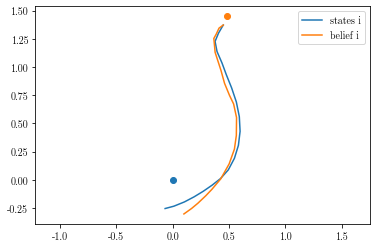

In [60]:
from plot_ult import convert_location_to_relative
i -= 1
# # y downsampled
# rel_dist, rel_ang, abs_dist, abs_ang,hor_theta, ver_theta, hor_theta_, ver_theta_,fx, fy, mx, my, mv, mw=zip(*eval(m)['m53s31Ydownsampled'][i][1])
# plt.plot(np.array(my)/worldscale,np.array(mx)/worldscale, label='ydownsample')
# # print(np.array(my)/worldscale)

# ------ overhead coord ------
# states
mx, my, body_theta,  mv, mw = zip(*states[i])
mx, my, body_theta,  mv, mw = np.array(torch.tensor(mx)), np.array(torch.tensor(my)), np.array(
    torch.tensor(body_theta)), np.array(torch.tensor(mv)), np.array(torch.tensor(mw))
smx, smy = mx, my
# print('s',mx)

# beliefs
ep_beliefs, ep_covs, task = beliefs[i], covs[i], tasks[i]
mx, my, body_theta,  mv, mw = zip(*ep_beliefs)
mx, my, body_theta,  mv, mw = np.array(torch.tensor(mx)), np.array(torch.tensor(my)), np.array(
    torch.tensor(body_theta)), np.array(torch.tensor(mv)), np.array(torch.tensor(mw))
bmx, bmy = mx, my

# plt.plot(smy, smx, label='states')
# plt.plot(bmy, bmx, label='belief')
# plt.scatter(task[1], task[0])
# plt.scatter(0,0)
# plt.title(f'world coord {sessionll[i]}')
# plt.axis('equal')
# plt.legend()
# plt.show()


def mse(a, b):
    return sum((a-b)**2)/len(b)


print(mse(smx, smy) - mse(bmx, bmy))


# ------- eye coord -------------------
# states
mx, my, body_theta,  mv, mw = zip(*states[i])
mx, my, body_theta,  mv, mw = np.array(torch.tensor(mx)), np.array(torch.tensor(my)), np.array(
    torch.tensor(body_theta)), np.array(torch.tensor(mv)), np.array(torch.tensor(mw))
smx, smy = mx, my

s_rel_lat, s_rel_for = convert_location_to_relative(
    mx,
    my,
    np.rad2deg(body_theta),
    task[0],
    task[1])
# s_hor_theta_, s_ver_theta_ = convert_rel_location_to_angle(-s_rel_for, s_rel_lat)
rel_dist = ((mx-task[0])**2+(my-task[1])**2)**0.5
fx, fy = task[1], task[0]
body_x, body_y = my, mx
s_hor_theta_, s_ver_theta_ = convert_location_to_angle(
                                            abs(rel_dist).reshape(-1), fy.reshape(-1), fx.reshape(-1),
                                            (body_theta)+np.deg2rad(90), body_y.reshape(-1), body_x.reshape(-1),
                                            mx.reshape(-1), mx.reshape(-1),remove_pre=False)
# print(s_hor_theta_)

# beliefs
ep_beliefs, ep_covs, task = beliefs[i], covs[i], tasks[i]
mx, my, body_theta,  mv, mw = zip(*ep_beliefs)
mx, my, body_theta,  mv, mw = np.array(torch.tensor(mx)), np.array(torch.tensor(my)), np.array(
    torch.tensor(body_theta)), np.array(torch.tensor(mv)), np.array(torch.tensor(mw))
bmx, bmy = mx, my

b_rel_lat, b_rel_for = convert_location_to_relative(
    mx,
    my,
    np.rad2deg(body_theta),
    task[0],
    task[1])

b_hor_theta_, b_ver_theta_ = convert_rel_location_to_angle(
    -b_rel_for, b_rel_lat)


# eye
eye_hori, eye_vert = session_eye_hori[i], session_eye_vert[i]
eye_hori_, eye_vert_ = session_eye_hori_[i], session_eye_vert_[i]

plt.plot(s_rel_for, s_rel_lat, label='states i')
plt.plot(b_rel_for, b_rel_lat, label='belief i')
plt.axis('equal')
plt.legend()
plt.scatter(0, 0)
plt.scatter(task[1], task[0])
plt.title(f'world relative coord {sessionll[i]}')
plt.show()


plt.plot(eye_hori, eye_vert, label='eye')
plt.plot(eye_hori_, eye_vert_+1, label='eye _')
plt.plot(s_hor_theta_, s_ver_theta_, label='states i')
plt.plot(b_hor_theta_, b_ver_theta_, label='belief i')
plt.axis('equal')
plt.legend()
plt.scatter(0, 0)
plt.title(f'eye coord {sessionll[i]}')
plt.show()


print(mse(s_hor_theta_.reshape(-1), eye_hori),
      mse(s_ver_theta_.reshape(-1), eye_vert), 'state')
print(mse(b_hor_theta_.reshape(-1), eye_hori),
      mse(b_ver_theta_.reshape(-1), eye_vert), 'belief')

In [61]:
i-=1

session_eye_hori=[]
session_eye_vert=[]
for i in range(len(eval(m)['m53s31Ydownsampled'])):
    rel_dist, rel_ang, abs_dist, abs_ang,hor_theta, ver_theta, hor_theta_, ver_theta_,fx, fy, mx, my, mv, mw=zip(*eval(m)['m53s31Ydownsampled'][i][1])
    # model data
    # plt.plot(a[i][:,0],a[i][:,1],)
    # plt.scatter( c[i][0],c[i][1],)
    # plt.plot(np.array(my)/worldscale,np.array(mx)/worldscale)
    # plt.axis('equal')
    # plt.title(i)
    # plt.show()
    session_eye_hori.append(np.array(hor_theta))
    session_eye_vert.append(np.array(ver_theta))

    
eye_hori, eye_vert = session_eye_hori[i], session_eye_vert[i]

plt.plot(s_rel_for, s_rel_lat, label='states i')
plt.plot(b_rel_for, b_rel_lat, label='belief i')
plt.axis('equal')
plt.legend()
plt.scatter(0,0)
plt.scatter(task[1], task[0])
plt.title(f'world relative coord {sessionll[i]}')
plt.show()

KeyError: 'm53s31Ydownsampled'

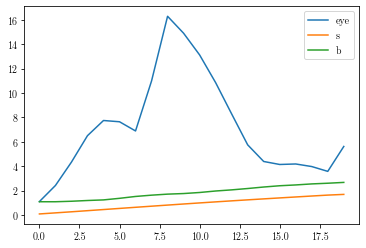

In [62]:
plt.plot(eye_hori, label='eye')
plt.plot(smx, label='s')
plt.plot(bmx+1, label='b')
plt.legend()


In [63]:
session_eye_hori=[]
session_eye_vert=[]
for i in range(len(eval(m)['m53s31Ydownsampled'])):
    rel_dist, rel_ang, abs_dist, abs_ang,hor_theta, ver_theta, hor_theta_, ver_theta_,fx, fy, mx, my, mv, mw=zip(*eval(m)['m53s31Ydownsampled'][i][1])
    # model data
    # plt.plot(a[i][:,0],a[i][:,1],)
    # plt.scatter( c[i][0],c[i][1],)
    # plt.plot(np.array(my)/worldscale,np.array(mx)/worldscale)
    # plt.axis('equal')
    # plt.title(i)
    # plt.show()
    session_eye_hori.append(np.array(hor_theta))
    session_eye_vert.append(np.array(ver_theta))
session_eye_hori

KeyError: 'm53s31Ydownsampled'

# old analysis

## belief eye correlation


In [64]:
ll=irc_ll['m53s31Ydownsampled_irc_ll']
len(ll)
y=eval(m)['m53s31Ydownsampled']
trial_idces, yy = zip(*y)
all_hor_theta=[]
for itrial in range(len(trial_idces)):
    rel_dist, rel_ang, abs_dist, abs_ang,hor_theta, ver_theta, hor_theta_, ver_theta_,fx, fy, mx, my, mv, mw=zip(*yy[itrial])
    all_hor_theta.append(hor_theta)
len(all_hor_theta),len(beliefs), len(covs), len(states)

KeyError: 'm53s31Ydownsampled_irc_ll'

## 